In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

con = sqlite3.connect("csgo.db")

csgo_df = pd.read_sql_query("SELECT * FROM round INNER JOIN game WHERE round.game_id = game.id", con, parse_dates=["time"])
players_df = pd.read_sql_query("SELECT * from players", con)
csgo_df['time'] = pd.to_datetime(csgo_df['time'], utc=True)

In [3]:
csgo_df['survivingCount'] =  csgo_df.survivingPlayers.apply(lambda x: len(x[1:-1].split(',')) if x != 'null' else 0)
csgo_df['longestKillWaitS'] = csgo_df['longestKillWait']/csgo_df['tickrate']

In [4]:
csgo_df

,round_id,game_id,duration,losingTeamName,losingSide,startTick,endTick,endOfficialTick,survivingPlayers,losingTeamLeftoverMoney,...,id,time,team_a,team_b,team_a_players,team_b_players,map,tickrate,survivingCount,longestKillWaitS
0,1,1,78,Team LDLC.com,3,4992,15016,15915,null,7950,...,1,2014-11-30 00:34:14+00:00,Team LDLC.com,Ninjas in Pyjamas,"[76561198000782895,76561197978241352,765611980...","[76561197982036918,76561197961191700,765611979...",de_dust2,128,0,7.2500
1,2,1,97,Team LDLC.com,3,17835,30283,31181,null,9800,...,1,2014-11-30 00:34:14+00:00,Team LDLC.com,Ninjas in Pyjamas,"[76561198000782895,76561197978241352,765611980...","[76561197982036918,76561197961191700,765611979...",de_dust2,128,0,33.0000
2,3,1,87,Team LDLC.com,3,33101,44341,45237,"[""LDLC NBKTANK- * CMSTORM"",""LDLC Happy * CMSTO...",21800,...,1,2014-11-30 00:34:14+00:00,Team LDLC.com,Ninjas in Pyjamas,"[76561198000782895,76561197978241352,765611980...","[76561197982036918,76561197961191700,765611979...",de_dust2,128,5,0.0000
3,4,1,87,Ninjas in Pyjamas,2,47157,58365,59267,null,36950,...,1,2014-11-30 00:34:14+00:00,Team LDLC.com,Ninjas in Pyjamas,"[76561198000782895,76561197978241352,765611980...","[76561197982036918,76561197961191700,765611979...",de_dust2,128,0,11.3750
4,5,1,105,Ninjas in Pyjamas,2,61179,74619,75521,"[""Xizt Xtrfy""]",20500,...,1,2014-11-30 00:34:14+00:00,Team LDLC.com,Ninjas in Pyjamas,"[76561198000782895,76561197978241352,765611980...","[76561197982036918,76561197961191700,765611979...",de_dust2,128,1,7.5625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19297,19298,724,86,Team EnVyUs,2,254671,265727,266626,null,13850,...,724,2015-03-14 21:25:16+00:00,Team EnVyUs,Ninjas in Pyjamas,"[76561198000782895,76561197978241352,765611980...","[76561197984560929,76561197982036918,765611979...",de_dust2,128,0,17.1875
19298,19299,724,60,Team EnVyUs,2,268546,276290,277190,null,18250,...,724,2015-03-14 21:25:16+00:00,Team EnVyUs,Ninjas in Pyjamas,"[76561198000782895,76561197978241352,765611980...","[76561197984560929,76561197982036918,765611979...",de_dust2,128,0,22.6250
19299,19300,724,67,Ninjas in Pyjamas,3,279110,287742,288644,null,16500,...,724,2015-03-14 21:25:16+00:00,Team EnVyUs,Ninjas in Pyjamas,"[76561198000782895,76561197978241352,765611980...","[76561197984560929,76561197982036918,765611979...",de_dust2,128,0,15.3125
19300,19301,724,79,Team EnVyUs,2,290564,300772,301674,null,12000,...,724,2015-03-14 21:25:16+00:00,Team EnVyUs,Ninjas in Pyjamas,"[76561198000782895,76561197978241352,765611980...","[76561197984560929,76561197982036918,765611979...",de_dust2,128,0,19.1250


In [5]:
yearly_average = csgo_df.resample("Y", on="time")
yearly_average.mean().dropna()

/tmp/ipykernel_382/109468099.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  yearly_average.mean().dropna()


,round_id,game_id,duration,losingSide,startTick,endTick,endOfficialTick,losingTeamLeftoverMoney,equipmentSavedValue,longestKillWait,lastKillToEnd,round_no,heDamage,id,tickrate,survivingCount,longestKillWaitS
time,,,,,,,,,,,,,,,,,
2014-12-31 00:00:00+00:00,6029.093592,227.590462,77.489121,2.412817,187289.440537,196806.410134,199110.782116,20226.304024,728.777943,2665.156185,462.064083,12.662593,0.000000,227.590462,128.0,0.174069,20.821533
2015-12-31 00:00:00+00:00,15448.070339,578.745763,75.518220,2.443644,180899.211441,190113.315678,192172.304661,16399.957627,993.008475,2515.513983,585.606356,12.772881,18.436017,578.745763,128.0,0.221610,19.652453
2016-12-31 00:00:00+00:00,7492.030459,281.972844,81.994862,2.477798,213775.664954,223782.119266,226515.080000,19673.155963,971.688073,2806.564037,644.582385,13.342018,26.135046,281.972844,128.0,0.256881,21.926282
2017-12-31 00:00:00+00:00,13869.469315,520.078285,85.276161,2.435877,223917.385523,234176.409913,238941.440205,19558.654603,1256.845004,2901.638080,701.755704,13.249410,23.412667,520.078285,128.0,0.326515,22.669048
2019-12-31 00:00:00+00:00,12425.598478,465.266836,82.585799,2.266272,234649.822767,227793.688926,247993.743308,20529.909834,2212.975486,3307.487743,977.716258,13.686109,25.261200,465.266836,128.0,0.523810,25.839748
2021-12-31 00:00:00+00:00,10131.000000,379.487658,90.317060,2.419089,217485.490400,228516.596270,230317.986835,20816.758091,1997.202414,3408.556775,1081.537575,13.244103,33.112452,379.487658,128.0,0.443774,26.629350
2022-12-31 00:00:00+00:00,3856.500000,146.589552,89.905360,2.445726,232251.232022,243162.265604,244786.142469,20888.839891,2012.042062,3245.373474,1134.177069,13.677748,32.427748,146.589552,128.0,0.446065,25.354480


In [6]:
monthly_average = csgo_df.resample("M", on="time")
monthly_average.mean().dropna()

/tmp/ipykernel_382/2198300793.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_average.mean().dropna()


,round_id,game_id,duration,losingSide,startTick,endTick,endOfficialTick,losingTeamLeftoverMoney,equipmentSavedValue,longestKillWait,lastKillToEnd,round_no,heDamage,id,tickrate,survivingCount,longestKillWaitS
time,,,,,,,,,,,,,,,,,
2014-03-31 00:00:00+00:00,1363.000000,54.246871,76.517634,2.455063,183883.199090,193149.213879,195122.092150,20454.550626,790.614334,2642.104664,517.871445,12.588168,0.000000,54.246871,128.0,0.188851,20.641443
2014-08-31 00:00:00+00:00,11978.819060,449.455892,79.781069,2.424340,196969.877656,206823.629105,208904.111397,20211.493883,770.895042,2723.495815,457.594977,12.806825,0.000000,449.455892,128.0,0.179008,21.277311
2014-11-30 00:00:00+00:00,462.000000,19.369447,74.557963,2.353196,174245.418202,183434.724810,186431.495125,20033.856988,599.024919,2588.949079,416.436620,12.490791,0.000000,19.369447,128.0,0.151679,20.226165
2015-03-31 00:00:00+00:00,18830.500000,705.368644,76.106992,2.408898,176182.807203,185597.330508,187537.633475,19484.904661,963.241525,2511.957627,609.944915,12.315678,0.000000,705.368644,128.0,0.212924,19.624669
2015-08-31 00:00:00+00:00,13836.500000,518.251579,75.109474,2.466316,185157.882105,194123.612632,196522.395789,11787.315789,1034.631579,2498.976842,578.362105,13.090526,31.738947,518.251579,128.0,0.238947,19.523257
2015-10-31 00:00:00+00:00,11686.000000,437.986667,79.200000,2.466667,164091.333333,173814.266667,175257.200000,19048.666667,1098.000000,2415.306667,753.173333,12.013333,34.413333,437.986667,128.0,0.240000,18.869583
2015-11-30 00:00:00+00:00,11919.000000,447.017903,74.383632,2.468031,185162.994885,194399.086957,196037.204604,19651.023018,943.606138,2583.501279,512.304348,13.250639,27.560102,447.017903,128.0,0.196931,20.183604
2016-03-31 00:00:00+00:00,11345.500000,424.866337,75.120462,2.460396,185338.661716,194578.495050,196734.117162,19325.907591,958.498350,2617.965347,532.051155,12.881188,34.846535,424.866337,128.0,0.249175,20.452854
2016-04-30 00:00:00+00:00,6950.500000,261.871743,84.291583,2.510020,228674.474950,239135.340681,241480.592184,19978.406814,920.390782,2858.825651,652.044088,13.984970,25.575150,261.871743,128.0,0.232465,22.334575


In [7]:
duration_plot = monthly_average[["time", "duration"]].mean().dropna()
duration_plot

/tmp/ipykernel_382/700359980.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  duration_plot = monthly_average[["time", "duration"]].mean().dropna()


,duration
time,
2014-03-31 00:00:00+00:00,76.517634
2014-08-31 00:00:00+00:00,79.781069
2014-11-30 00:00:00+00:00,74.557963
2015-03-31 00:00:00+00:00,76.106992
2015-08-31 00:00:00+00:00,75.109474
2015-10-31 00:00:00+00:00,79.200000
2015-11-30 00:00:00+00:00,74.383632
2016-03-31 00:00:00+00:00,75.120462
2016-04-30 00:00:00+00:00,84.291583


<Axes: xlabel='time'>

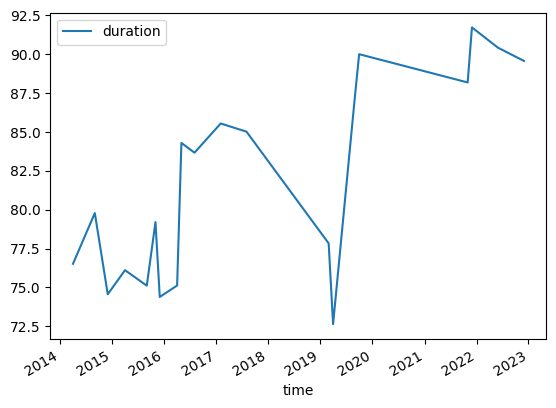

In [8]:
duration_plot.plot()

/tmp/ipykernel_382/683167702.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  survivingp_plot = monthly_average[["time", "survivingCount"]].mean().dropna()


<Axes: xlabel='time'>

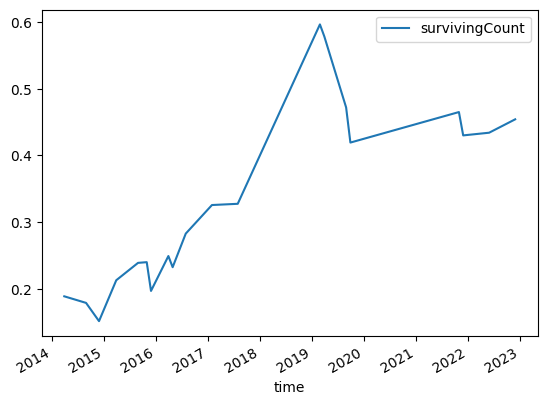

In [9]:
survivingp_plot = monthly_average[["time", "survivingCount"]].mean().dropna()
survivingp_plot.plot()

/tmp/ipykernel_382/538616652.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  longestkill_plot = monthly_average[["time", "longestKillWaitS"]].mean().dropna()


<Axes: xlabel='time'>

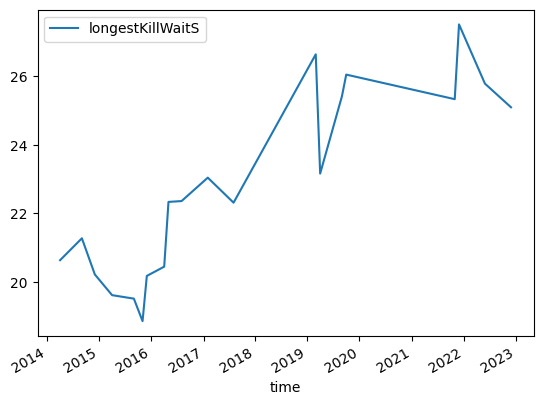

In [10]:
longestkill_plot = monthly_average[["time", "longestKillWaitS"]].mean().dropna()
longestkill_plot.plot()

In [11]:
csgo_df["team_a_players_str"] = csgo_df.team_a_players.apply(lambda x: str(sorted(x[1:-1].split(','))))
csgo_df["team_b_players_str"] = csgo_df.team_b_players.apply(lambda x: str(sorted(x[1:-1].split(','))))
csgo_df["losingPlayers"] = np.where(csgo_df["losingTeamName"].equals(csgo_df["team_a"]),  csgo_df["team_a_players"], csgo_df["team_b_players"])
csgo_df["losingPlayers_str"] = np.where(csgo_df["losingTeamName"].equals(csgo_df["team_a"]),  csgo_df["team_a_players_str"], csgo_df["team_b_players_str"])

In [12]:
csgo_df.map.explode().value_counts()

de_mirage      3213
de_inferno     3209
de_dust2       2576
de_overpass    2248
de_nuke        1925
de_cbble       1658
de_train       1602
de_cache       1288
de_vertigo      878
de_ancient      705
Name: map, dtype: int64

In [13]:
survivingRounds = csgo_df.loc[csgo_df["survivingCount"] > 0]

In [14]:
survivingRounds.losingPlayers.explode().value_counts()

[76561198002942763,76561198068422762,76561197991272318,76561198061801241,76561198093386355]    23
[76561197997351207,76561198041683378,76561197988627193,76561197972331023,76561198006466707]    17
[76561198011536764,76561197961491680,76561198050644501,76561197961427893,76561197981508015]    17
[76561197999186947,76561197983031494,76561197960690195,76561198039986599,76561198013142296]    16
[76561197998926770,76561198120557348,76561198073117127,76561197991234691,76561198158377244]    16
                                                                                               ..
[76561197972003061,76561198024905796,76561197960710573,76561197988768248,76561197974587647]     1
[76561198000078546,76561197960301489,76561198000020858,76561197989744167,76561197978241352]     1
[76561197991348083,76561197988627193,76561197969684910,76561198031651584,76561198031554200]     1
[76561197987713664,76561197971478380,76561198004854956,76561197990682262,76561197978328043]     1
[76561198023592320,7

In [15]:
survivingRounds.losingPlayers_str.explode().value_counts()

['76561197965809411', '76561197977105184', '76561197985097994', '76561198002708642', '76561198072321716']    101
['76561197960499780', '76561197960725934', '76561197973845818', '76561197979126082', '76561197982141573']    101
['76561197983956651', '76561197987713664', '76561197990682262', '76561198004854956', '76561198010511021']     87
['76561198028292758', '76561198045433304', '76561198059714128', '76561198081484775', '76561198208074320']     82
['76561197995817501', '76561198036125584', '76561198127236290', '76561198134401925', '76561198173201923']     78
                                                                                                            ... 
['76561197971478380', '76561197978328043', '76561197987713664', '76561197990682262', '76561198004854956']      1
['76561197988627193', '76561197991348083', '76561198031554200', '76561198031651584']                           1
['76561197960784488', '76561197967489380', '76561197977830434', '76561197978481975']            

In [16]:
survivingRounds.losingPlayers_str.explode()

2        ['76561197960359452', '76561197961191700', '76...
4        ['76561197960359452', '76561197961191700', '76...
7        ['76561197960359452', '76561197961191700', '76...
9        ['76561197960359452', '76561197961191700', '76...
11       ['76561197960359452', '76561197961191700', '76...
                               ...                        
19269    ['76561197960359452', '76561197961610974', '76...
19271    ['76561197960359452', '76561197961610974', '76...
19275    ['76561197960359452', '76561197961610974', '76...
19287    ['76561197960359452', '76561197961610974', '76...
19294    ['76561197960359452', '76561197961610974', '76...
Name: losingPlayers_str, Length: 3633, dtype: object

In [17]:
survivingRounds.losingPlayers.explode()

2        [76561197982036918,76561197961191700,765611979...
4        [76561197982036918,76561197961191700,765611979...
7        [76561197982036918,76561197961191700,765611979...
9        [76561197982036918,76561197961191700,765611979...
11       [76561197982036918,76561197961191700,765611979...
                               ...                        
19269    [76561197982036918,76561197960359452,765611979...
19271    [76561197982036918,76561197960359452,765611979...
19275    [76561197984560929,76561197982036918,765611979...
19287    [76561197984560929,76561197982036918,765611979...
19294    [76561197984560929,76561197982036918,765611979...
Name: losingPlayers, Length: 3633, dtype: object